In [3]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display, HTML


In [4]:
# Загрузка данных
file_path = "MainDF.csv"  # Укажите путь к вашему CSV-файлу
df = pd.read_csv(file_path, na_values=[''])
df = df.sort_values(by=["Компания", "year"])

C:\Users\Home\AppData\Local\Temp\ipykernel_19112\3630744442.py:3: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(file_path, na_values=[''])


In [5]:
# Загрузка данных об инфляции
inflation_data = pd.read_csv("inflation.csv")

# Преобразование столбца "Год" в int для соответствия с "year" в df
inflation_data["Год"] = inflation_data["Год"].astype(int)

# Создание словаря для быстрого маппинга года на инфляцию
inflation_dict = inflation_data.set_index("Год")["Всего"].to_dict()

# Добавление инфляции в DataFrame df
df["inflation"] = df["year"].map(inflation_dict)

# Проверка результата
print(df[["year", "inflation"]].head())

   year  inflation
0  2018       4.27
1  2019       3.05
2  2020       4.91
3  2021       8.39
4  2022      11.92


In [6]:
# Удаление компании с названием "ЗСД (Западный скоростной диаметр)"
df = df[df['Компания'] != 'ЗСД (Западный скоростной диаметр)']

In [7]:
start_col = df.columns.get_loc("size_cat") + 1
end_col = df.columns.get_loc("year")  # Определяем конец финансовых показателей

# Выбираем только финансовые показатели
financial_data = df.iloc[:, start_col:end_col]

In [8]:
# Удаление строк, где отсутствуют все финансовые данные
cleaned_df = df.dropna(thresh=len(financial_data.columns) - 6, subset=financial_data.columns)

# Сортировка данных по году для каждой компании
cleaned_df = cleaned_df.sort_values(by=["Компания", "year"])

print(f"Удалено {len(df) - len(cleaned_df)} строк, где отсутствовали финансовые данные.")

Удалено 11137 строк, где отсутствовали финансовые данные.


In [9]:
# Определяем компании с разными значениями в столбце "industry"
companies_with_different_industries = cleaned_df.groupby("Компания")["industry"].nunique()
companies_with_different_industries = companies_with_different_industries[companies_with_different_industries > 1].index

# Фильтрация исходного датасета
cleaned_df = cleaned_df[~cleaned_df['Компания'].isin(companies_with_different_industries)]

# Определяем компании с одинаковым значением в столбце "name", но разными значениями в столбце "Компания"
names_with_different_companies = cleaned_df.groupby("name")["Компания"].nunique()
names_with_different_companies = names_with_different_companies[names_with_different_companies > 1].index

# Фильтрация исходного датасета
cleaned_df = cleaned_df[~cleaned_df['name'].isin(names_with_different_companies)]

cleaned_df = cleaned_df.groupby('Компания').filter(lambda x: len(x) > 4)

print(f"Удалено {len(companies_with_different_industries)} компаний, которые имеют разные значения в столбце 'industry'.")
print(f"Удалено {len(names_with_different_companies)} компаний, которые имеют одинаковое значение в столбце 'name', но разные значения в столбце 'Компания'.")
print(f"Удалено компаний с менее чем 5 наблюдениями: {len(df) - len(cleaned_df)}")

Удалено 50 компаний, которые имеют разные значения в столбце 'industry'.
Удалено 10 компаний, которые имеют одинаковое значение в столбце 'name', но разные значения в столбце 'Компания'.
Удалено компаний с менее чем 5 наблюдениями: 12835


In [10]:
# Удаление компаний, у которых ни в одном году нет внедрения технологий
companies_with_technology = cleaned_df.dropna(subset=['Технология'])['Компания'].unique()
cleaned_df = cleaned_df[cleaned_df['Компания'].isin(companies_with_technology)]

print(f"Удалено компаний без внедрения технологий: {len(df['Компания'].unique()) - len(cleaned_df['Компания'].unique())}")

# Подсчет удаленных компаний
original_companies = df['Компания'].unique()
cleaned_companies = cleaned_df['Компания'].unique()
removed_companies = set(original_companies) - set(cleaned_companies)

print(f"Удалено компаний, у которых все внедрения технологий приходятся на первые два года или последние два года: {len(removed_companies)}")


Удалено компаний без внедрения технологий: 1214
Удалено компаний, у которых все внедрения технологий приходятся на первые два года или последние два года: 1214


In [11]:
# Группировка данных по компаниям
grouped = cleaned_df.groupby('Компания')

# Функция для проверки пропущенных годов
def has_missing_years(group):
    years = group['year'].sort_values()
    return any(years.diff().dropna() > 1)

# Применение функции к каждой группе и подсчет количества компаний с пропущенными годами
companies_with_missing_years = grouped.filter(has_missing_years)['Компания'].nunique()

print(f"Количество компаний с пропущенными годами: {companies_with_missing_years}")

Количество компаний с пропущенными годами: 182


In [12]:
unique_company_count = cleaned_df['Компания'].nunique()
print(f"Unique count of 'Компания': {unique_company_count}")

Unique count of 'Компания': 794


In [13]:
df = cleaned_df

In [14]:
columns_to_drop = [
 'okved_name', 'short_term_liab', 'retained_earnings'
]
df = df.drop(columns=columns_to_drop)

In [15]:
start_col = df.columns.get_loc("size_cat") + 1
end_col = df.columns.get_loc("year")  # Определяем конец финансовых показателей
financial_columns = df.columns[start_col:end_col].tolist()
print(financial_columns)

['employees', 'income', 'expenses', 'intangibles', 'fixed_assets', 'noncurrent_assets', 'inventory', 'net_assets', 'receivables', 'current_assets', 'assets', 'lt_debt', 'st_debt', 'passive', 'nwc', 'equity', 'total_debt', 'sales', 'cgs', 'commercial', 'admin_expenses', 'interest_paid', 'ebt', 'eat', 'ebit', 'labor_costs', 'interest_payment', 'interest_coverage', 'net_profit_margin', 'ros']


In [16]:
# 3. Фильтрация МСП
msp_filter = df['size_cat'].isin(['Малые предприятия', 'Средние предприятия'])
df_msp = df[msp_filter]

# 5. Группировка по году и размеру предприятия
groups_year_size = df_msp.groupby(['year', 'size_cat'])

In [17]:
# Ensure 'employees' column is numeric
df_msp['employees'] = pd.to_numeric(df_msp['employees'], errors='coerce')

C:\Users\Home\AppData\Local\Temp\ipykernel_19112\2372959296.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_msp['employees'] = pd.to_numeric(df_msp['employees'], errors='coerce')


In [18]:
# Группировка данных по компаниям
grouped_companies = df_msp.groupby('Компания')

columns_to_drop = [
    'Технология', 'Продукт'
]

# Функция для расчета среднего значения финансовых показателей
def calculate_mean_financials(group):
    mean_financials = group[financial_columns].mean().round()
    first_row = group.iloc[0].drop(financial_columns)
    return pd.concat([first_row, mean_financials])

# Применение функции к каждой группе и создание нового датасета
mean_financials_df = grouped_companies.apply(calculate_mean_financials).reset_index(drop=True)

mean_financials_df = mean_financials_df.drop(columns=columns_to_drop)

C:\Users\Home\AppData\Local\Temp\ipykernel_19112\3154192920.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  mean_financials_df = grouped_companies.apply(calculate_mean_financials).reset_index(drop=True)


In [19]:
def calculate_bounds(df, group_col='size_cat', columns=None, std_multiplier=2):
    """
    Вычисляет границы (среднее ± std_multiplier * стандартное отклонение) для указанных столбцов.

    Параметры:
    - df: DataFrame с данными.
    - group_col: Название столбца для группировки (по умолчанию 'size_cat').
    - columns: Список столбцов, для которых нужно вычислить границы.
              Если None, используются все числовые столбцы.
    - std_multiplier: Множитель для стандартного отклонения (по умолчанию 2).

    Возвращает:
    - lower_bounds: Словарь с нижними границами для каждого столбца.
    - upper_bounds: Словарь с верхними границами для каждого столбца.
    """
    if columns is None:
        # Если columns не указан, используем все числовые столбцы
        columns = df.select_dtypes(include=['number']).columns

    # Вычисляем средние и стандартные отклонения
    mean_dict = df.groupby(group_col)[columns].mean().to_dict()
    std_dict = df.groupby(group_col)[columns].std().to_dict()

    # Вычисляем границы
    lower_bounds = {
        col: {group: mean_dict[col][group] - std_multiplier * std_dict[col][group] for group in mean_dict[col]}
        for col in columns
    }
    upper_bounds = {
        col: {group: mean_dict[col][group] + std_multiplier * std_dict[col][group] for group in mean_dict[col]}
        for col in columns
    }

    return lower_bounds, upper_bounds

In [20]:
def remove_outliers(df, group_col='size_cat', columns=None, std_multipliers=None):
    """
    Удаляет компании, которые выходят за пределы заданных границ для финансовых показателей.

    Параметры:
    - df: DataFrame с данными.
    - group_col: Название столбца для группировки (по умолчанию 'size_cat').
    - columns: Список столбцов, для которых нужно вычислить границы.
              Если None, используются все числовые столбцы.
    - std_multipliers: Словарь с множителями стандартного отклонения для каждого столбца.
                      Например, {'sales': 2, 'ros': 2, 'ebt': 2, 'assets': 1}.

    Возвращает:
    - df_filtered: Отфильтрованный DataFrame.
    - companies_removed: Список удалённых компаний.
    """
    if columns is None:
        # Если columns не указан, используем все числовые столбцы
        columns = df.select_dtypes(include=['number']).columns

    if std_multipliers is None:
        # Если множители не указаны, используем стандартные значения
        std_multipliers = {col: 2 for col in columns}

    # Вычисляем границы
    lower_bounds, upper_bounds = calculate_bounds(df, group_col=group_col, columns=columns)

    # Фильтруем компании, которые выходят за границы
    conditions = []
    for col in columns:
        if col in std_multipliers:
            if std_multipliers[col] > 0:
                # Верхняя граница
                conditions.append(df[col] > df[group_col].map(upper_bounds[col]))
            else:
                # Нижняя граница
                conditions.append(df[col] < df[group_col].map(lower_bounds[col]))

    # Объединяем условия с помощью логического ИЛИ
    combined_condition = pd.Series(False, index=df.index)
    for condition in conditions:
        combined_condition |= condition

    # Находим компании для удаления
    companies_to_remove = df[combined_condition]['Компания'].unique()

    # Удаляем компании из DataFrame
    df_filtered = df[~df['Компания'].isin(companies_to_remove)]

    print(f"Удалено компаний: {len(companies_to_remove)}")
    # print(f"Список удалённых компаний: {companies_to_remove}")

    return df_filtered, companies_to_remove

In [21]:
# Указываем множители для каждого столбца
std_multipliers = {
    'sales': 2,
    'ebt': 2,   
    'assets': 0.5,
    'receivables': 1
}

# Применяем функцию для удаления выбросов
mean_financials_df, removed_companies = remove_outliers(
    df=mean_financials_df,
    group_col='size_cat',
    columns=['sales', 'ebt', 'assets', 'receivables'],
    std_multipliers=std_multipliers
)

# Применяем фильтрацию ко второму DataFrame (если нужно)
df_msp = df_msp[~df_msp['Компания'].isin(removed_companies)]

Удалено компаний: 40


In [22]:
def filter_and_remove_companies(df, size_cat=None, employee_threshold=None, remove=False):
    """
    Фильтрует компании по категории размера и количеству сотрудников.
    Если remove=True, удаляет компании из DataFrame.

    Параметры:
    - df: DataFrame с данными.
    - size_cat: Категория размера компании (например, 'Малые предприятия').
    - employee_threshold: Пороговое значение количества сотрудников.
    - remove: Если True, удаляет компании из DataFrame.

    Возвращает:
    - filtered_companies: Отфильтрованные компании.
    - companies_to_remove: Список компаний для удаления (если remove=True).
    """
    if size_cat and employee_threshold:
        # Фильтрация по категории и количеству сотрудников
        condition = (df['size_cat'] == size_cat) & (df['employees'] > employee_threshold)
    elif employee_threshold:
        # Фильтрация только по количеству сотрудников
        condition = df['employees'] > employee_threshold
    else:
        raise ValueError("Необходимо указать size_cat и/или employee_threshold.")

    # Применяем условие
    filtered_companies = df[condition]

    if remove:
        # Удаляем компании из DataFrame
        companies_to_remove = filtered_companies['Компания'].unique()
        df_filtered = df[~df['Компания'].isin(companies_to_remove)]
        return df_filtered, companies_to_remove
    else:
        # Возвращаем отфильтрованные компании
        return filtered_companies, None

In [23]:
small_companies, _ = filter_and_remove_companies(
    df=mean_financials_df,
    size_cat='Малые предприятия',
    employee_threshold=100
)

# Фильтрация средних предприятий с количеством сотрудников больше 250
medium_companies, _ = filter_and_remove_companies(
    df=mean_financials_df,
    size_cat='Средние предприятия',
    employee_threshold=250
)

In [24]:
mean_financials_df, companies_to_remove = filter_and_remove_companies(
    df=mean_financials_df,
    employee_threshold=250,
    remove=True
)
df_msp = df_msp[~df_msp['Компания'].isin(companies_to_remove)]

# Удаление малых предприятий с количеством сотрудников больше 100
mean_financials_df, small_companies_to_remove = filter_and_remove_companies(
    df=mean_financials_df,
    size_cat='Малые предприятия',
    employee_threshold=100,
    remove=True
)
df_msp = df_msp[~df_msp['Компания'].isin(small_companies_to_remove)]

print(f"Удалено компаний с количеством сотрудников больше 250: {len(companies_to_remove)}")
print(f"Удалено малых предприятий с количеством сотрудников больше 100: {len(small_companies_to_remove)}")

Удалено компаний с количеством сотрудников больше 250: 95
Удалено малых предприятий с количеством сотрудников больше 100: 98


In [25]:
small_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Малые предприятия']
medium_enterprises = mean_financials_df[mean_financials_df['size_cat'] == 'Средние предприятия']

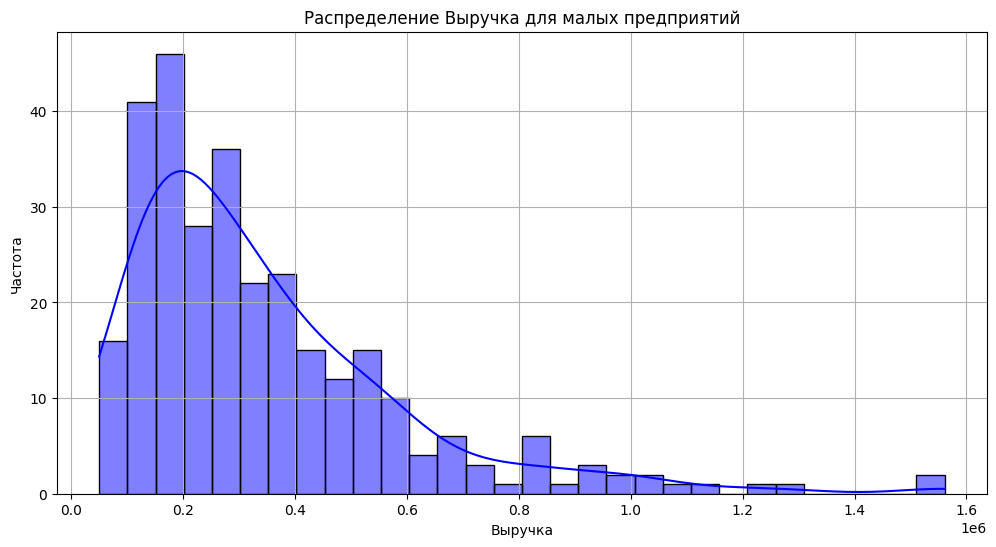

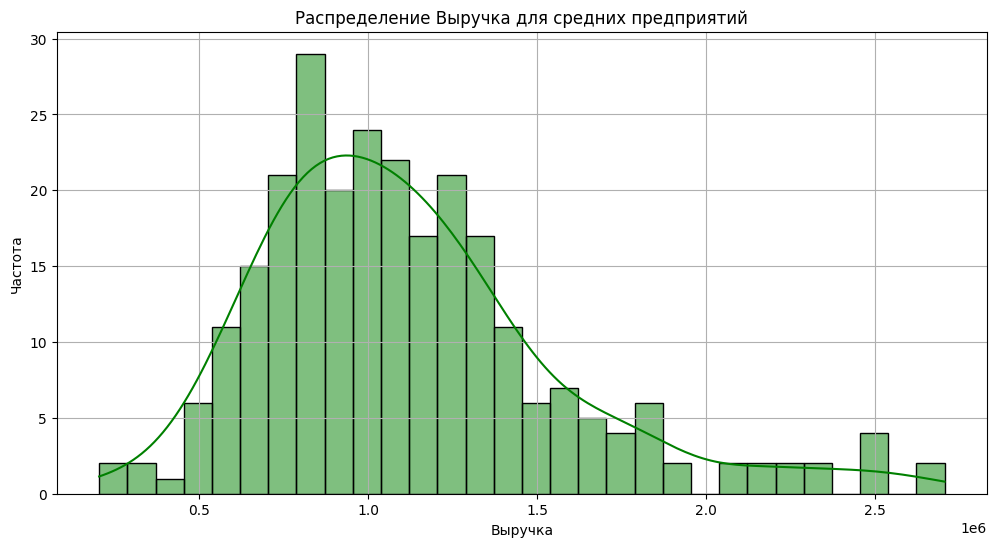

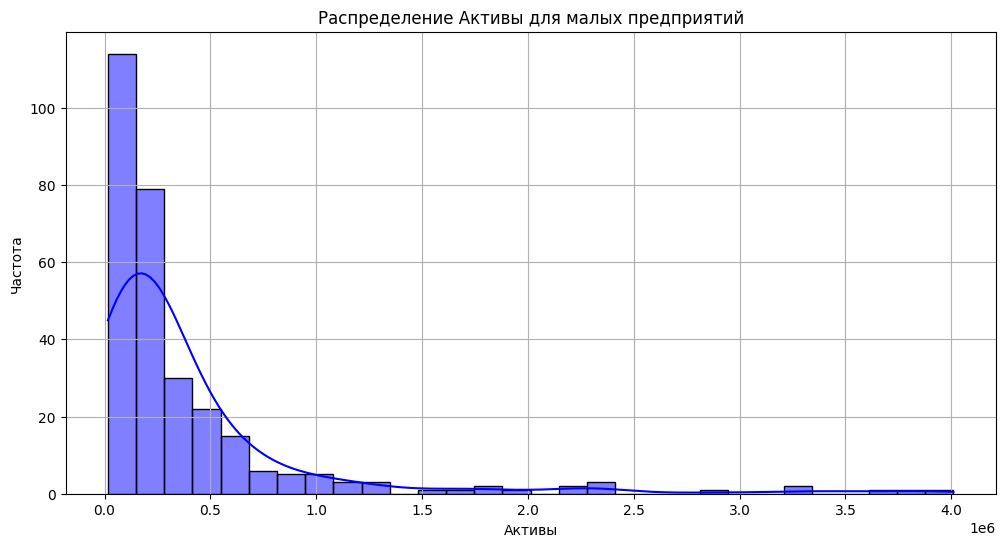

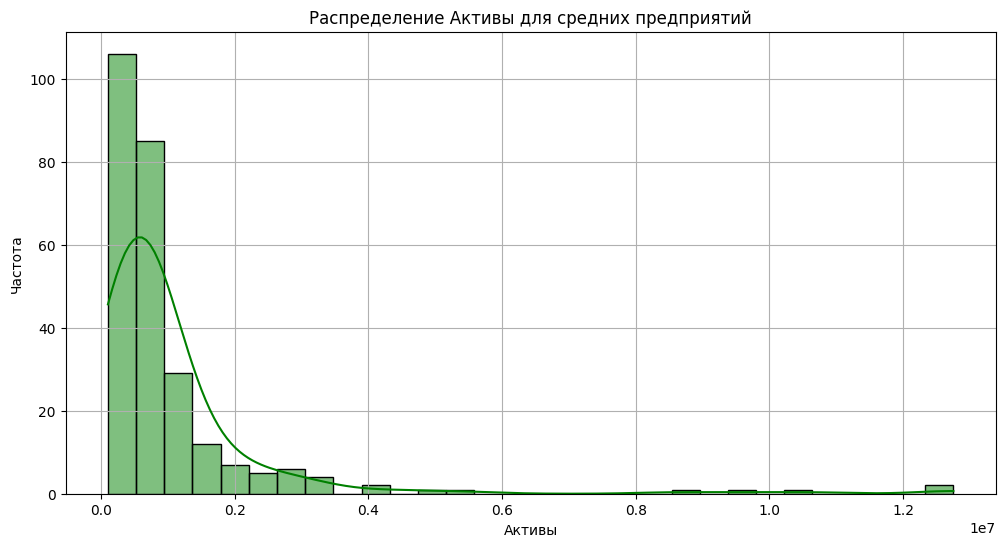

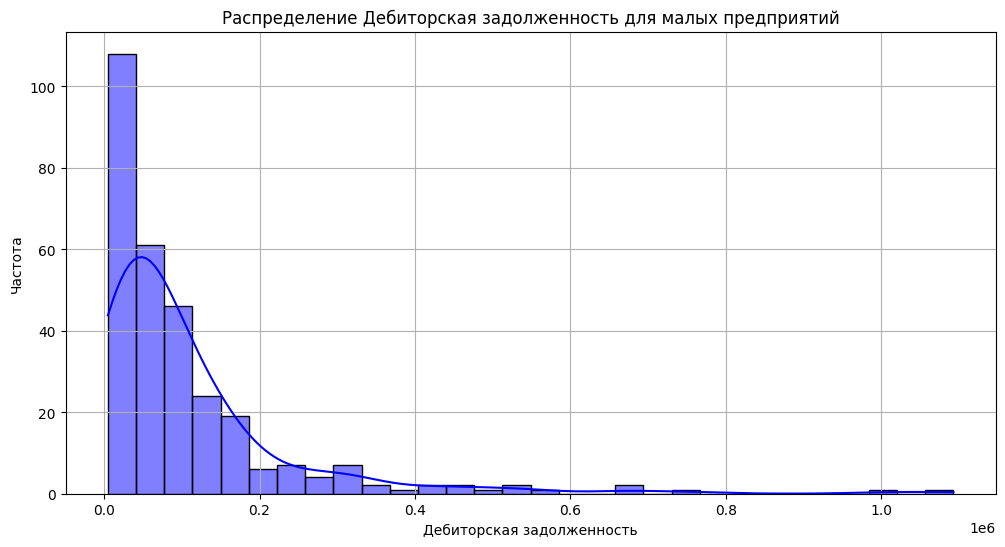

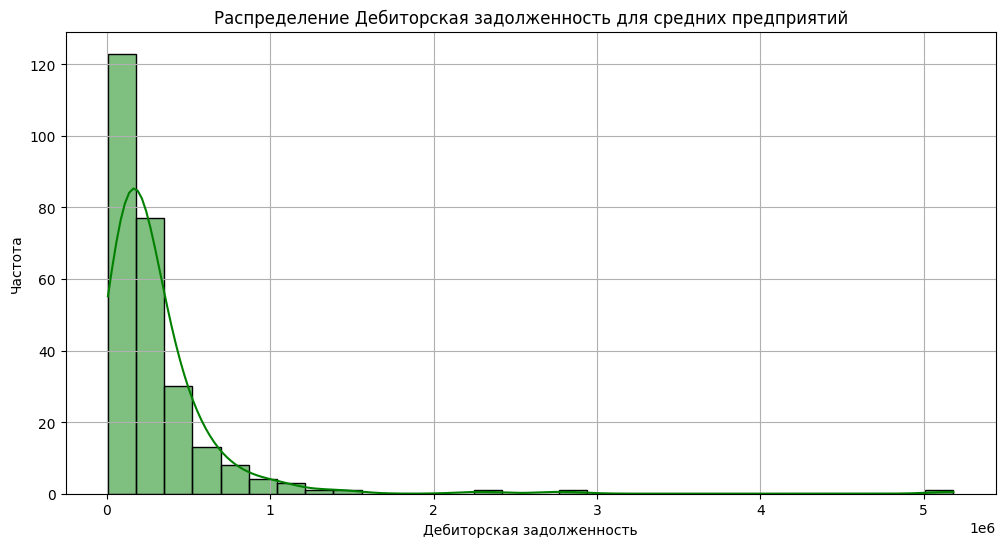

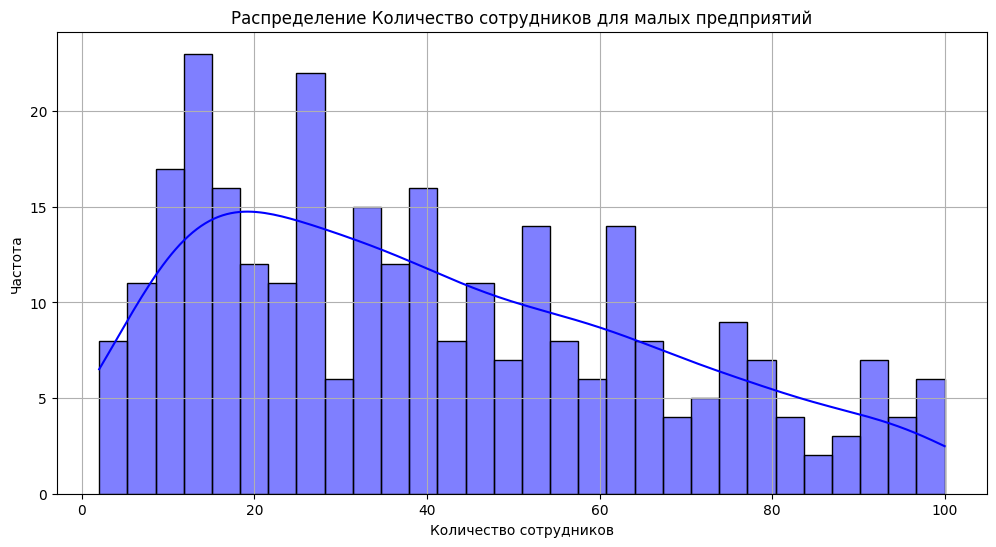

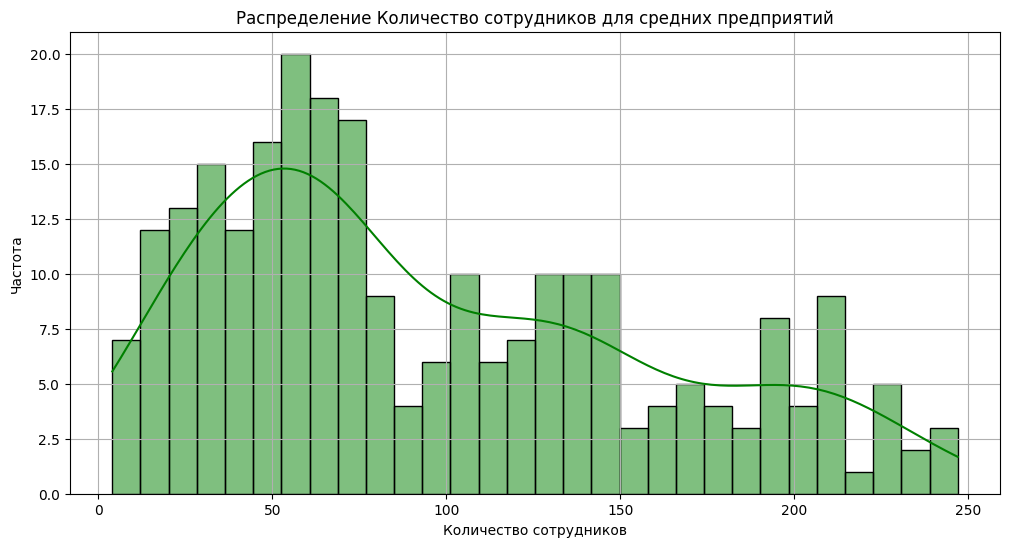

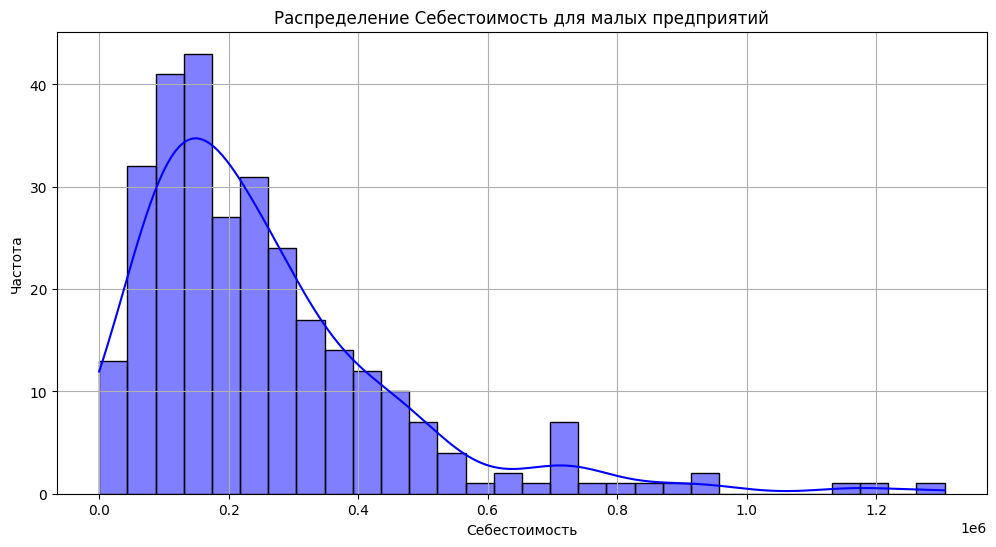

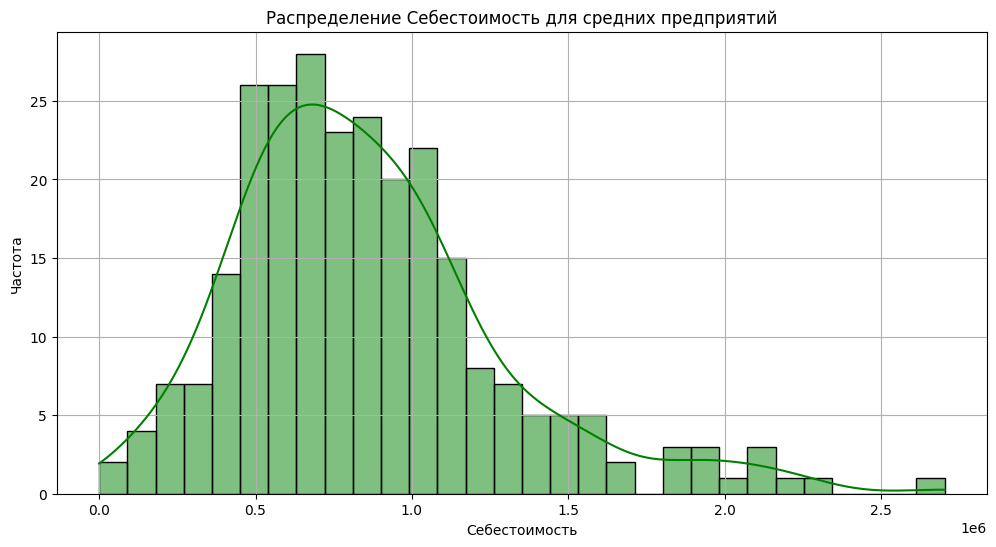

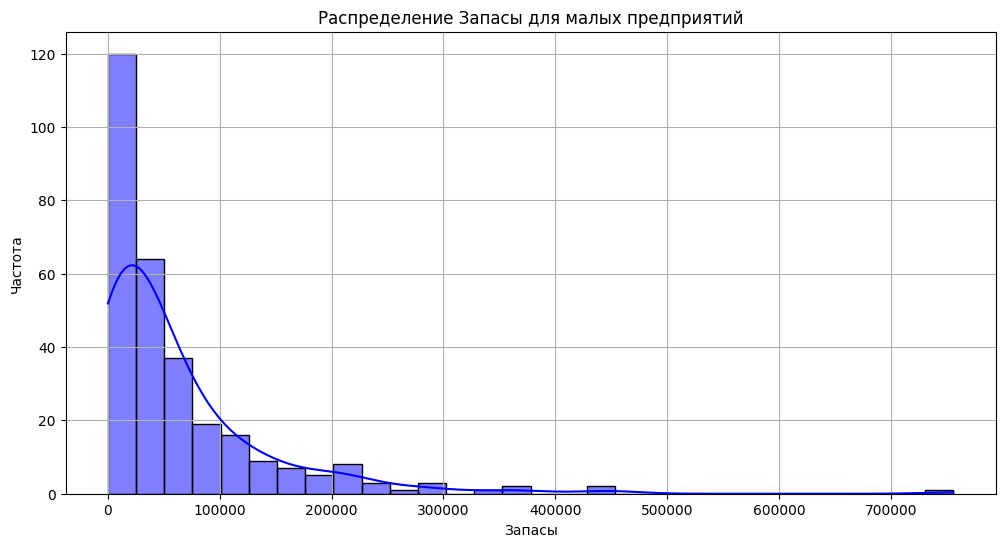

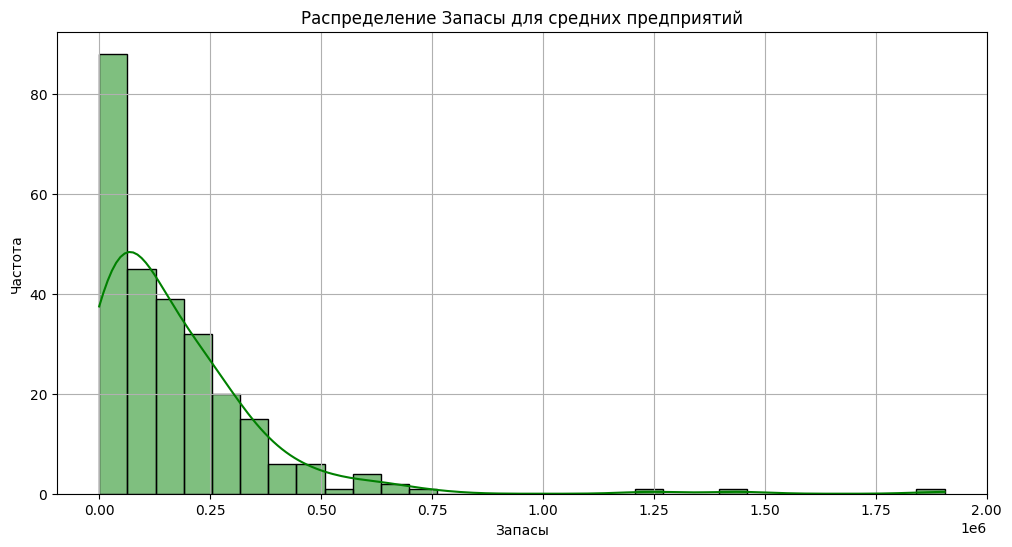

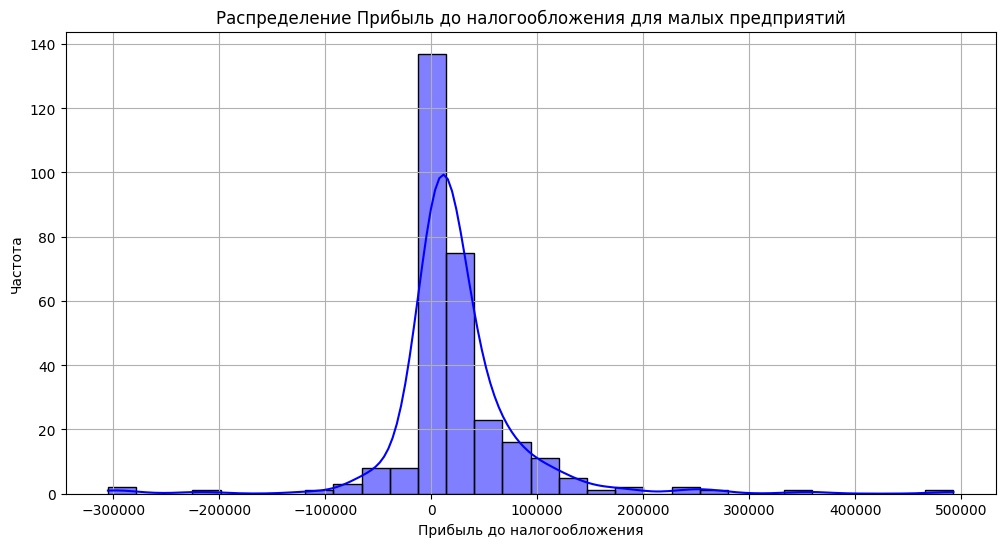

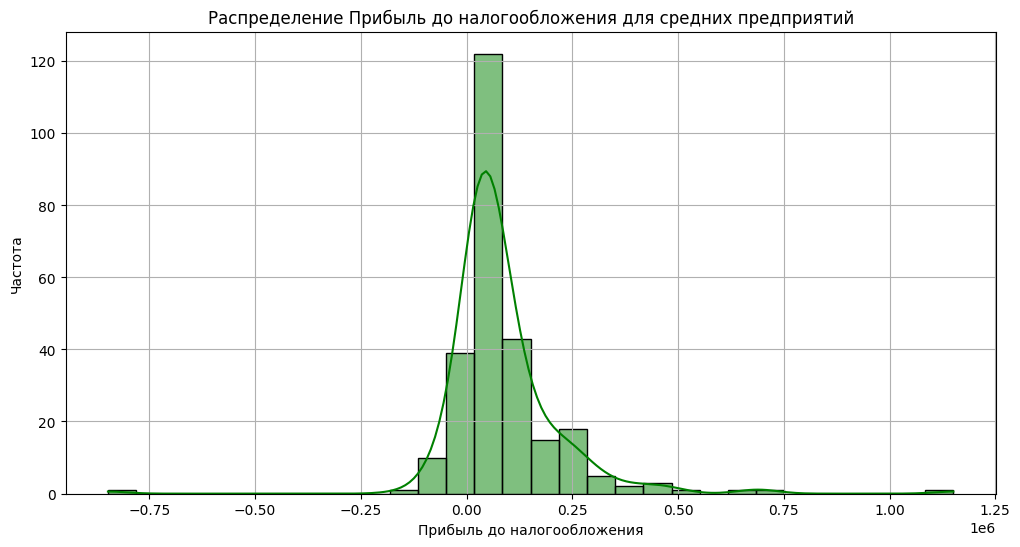

In [26]:
# Фильтрация данных для малых и средних предприятий
indicators = {
    'Выручка': 'sales',
    'Активы': 'assets',
    'Дебиторская задолженность': 'receivables',
    'Количество сотрудников': 'employees',
    'Себестоимость': 'cgs',
    'Запасы': 'inventory',
    'Прибыль до налогообложения': 'ebt',
    'Себестоимость': 'cgs'
}

for title, column in indicators.items():
    # Построение распределения для малых предприятий
    plt.figure(figsize=(12, 6))
    sns.histplot(small_enterprises[column], kde=True, bins=30, color='blue')
    plt.title(f'Распределение {title} для малых предприятий')
    plt.xlabel(title)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

    # Построение распределения для средних предприятий
    plt.figure(figsize=(12, 6))
    sns.histplot(medium_enterprises[column], kde=True, bins=30, color='green')
    plt.title(f'Распределение {title} для средних предприятий')
    plt.xlabel(title)
    plt.ylabel('Частота')
    plt.grid(True)
    plt.show()

<Figure size 1200x800 with 0 Axes>

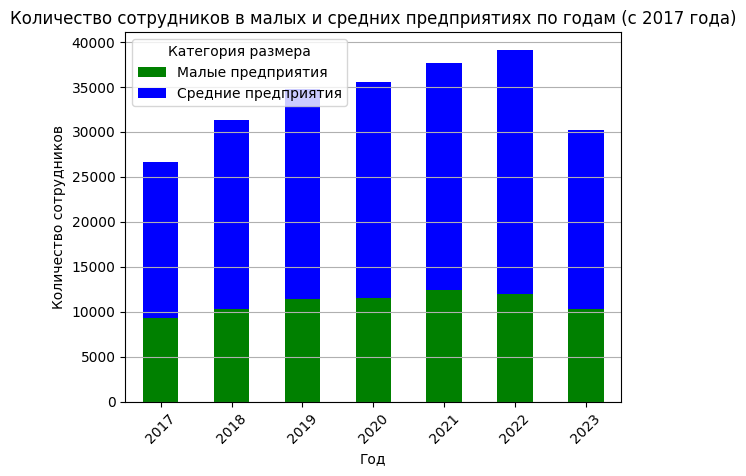

In [27]:
# Фильтрация данных с 2017 года
df_msp_filtered = df_msp[df_msp['year'] >= 2017]

# Группировка данных по годам и категориям размера
employees_counts_by_year = df_msp_filtered.groupby(['year', 'size_cat'])['employees'].sum().unstack(fill_value=0)

# Построение графика
plt.figure(figsize=(12, 8))
employees_counts_by_year.plot(kind='bar', stacked=True, color=['green', 'blue'])
plt.title('Количество сотрудников в малых и средних предприятиях по годам (с 2017 года)')
plt.xlabel('Год')
plt.ylabel('Количество сотрудников')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Категория размера')
plt.show()

<Figure size 1200x800 with 0 Axes>

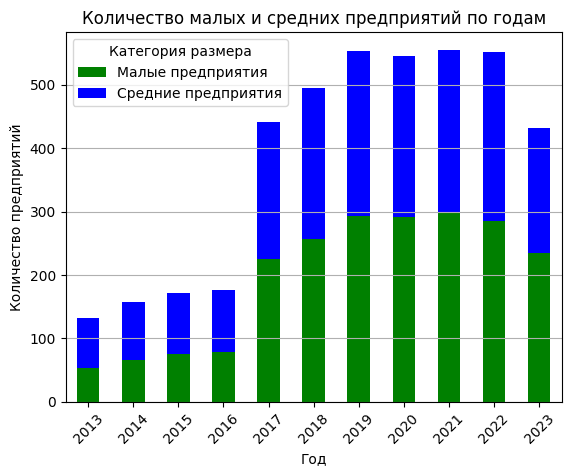

In [28]:
# Группировка данных по годам и категориям размера
size_counts_by_year = df_msp.groupby(['year', 'size_cat']).size().unstack(fill_value=0)

# Построение графика
plt.figure(figsize=(12, 8))
size_counts_by_year.plot(kind='bar', stacked=True, color=['green', 'blue'])
plt.title('Количество малых и средних предприятий по годам')
plt.xlabel('Год')
plt.ylabel('Количество предприятий')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.legend(title='Категория размера')
plt.show()

---

In [29]:
financial_columns = ['sales', 'assets', 'receivables', 'employees', 'cgs', 'inventory', 'ebt']

---

In [30]:
# Функция для вычисления всех статистик (min, max, mean, std, count, p-value)
def calculate_full_statistics(df, financial_columns):
    full_statistics = {}
    
    for col in financial_columns:
        small_values = df[df['size_cat'] == 'Малые предприятия'][col].dropna()
        medium_values = df[df['size_cat'] == 'Средние предприятия'][col].dropna()

        if len(small_values) > 1 and len(medium_values) > 1:
            t_stat, p_value = stats.ttest_ind(small_values, medium_values, equal_var=False, nan_policy='omit')
            full_statistics[col] = {
                'small_min': round(small_values.min(), 2),
                'small_max': round(small_values.max(), 2),
                # 'small_count': len(small_values),
                'small_mean_std': f"{round(small_values.mean(), 2)} ({round(small_values.std(), 2)})",
                
                'medium_min': round(medium_values.min(), 2),
                'medium_max': round(medium_values.max(), 2),
                # 'medium_count': len(medium_values),
                'medium_mean_std': f"{round(medium_values.mean(), 2)} ({round(medium_values.std(), 2)})",
                
                # 'p_value': round(p_value, 2),
                'significance': add_significance_stars(p_value)
            }
        else:
            full_statistics[col] = {
                'small_min': np.nan, 'small_max': np.nan, 'small_count': np.nan, 'small_mean_std': np.nan,
                'medium_min': np.nan, 'medium_max': np.nan, 'medium_count': np.nan, 'medium_mean_std': np.nan,
                'p_value': np.nan, 'significance': ''
            }
    
    return full_statistics

In [31]:
# Функция для добавления звездочек значимости
def add_significance_stars(p_value):
    if p_value < 0.01:
        return '***'
    elif p_value < 0.05:
        return '**'
    elif p_value < 0.1:
        return '*'
    else:
        return ''

In [32]:
# Вычисляем статистики
full_statistics = calculate_full_statistics(mean_financials_df, financial_columns)

# Создаем итоговую таблицу
full_comparison_table = pd.DataFrame.from_dict(full_statistics, orient='index').reset_index()
full_comparison_table.rename(columns={'index': 'Показатель'}, inplace=True)

# Переименовываем столбцы для лучшей читаемости
full_comparison_table = full_comparison_table.rename(columns={
    'small_min': 'Min (мал.)',
    'small_max': 'Max (мал.)',
    # 'small_count': 'N (мал.)',
    'small_mean_std': 'Mean (мал.) (std)',
    'medium_min': 'Min (сред.)',
    'medium_max': 'Max (сред.)',
    # 'medium_count': 'N (сред.)',
    'medium_mean_std': 'Mean (сред.) (std)',
    # 'p_value': 'p-value',
    'significance': 'Значимость'
})

# Вывод таблицы
print(full_comparison_table)
full_comparison_table.to_csv("full_comparison_table.csv", index=False)

    Показатель  Min (мал.)  Max (мал.)      Mean (мал.) (std)  Min (сред.)  \
0        sales     50378.0   1561000.0  344174.23 (246182.25)     203566.0   
1       assets     16149.0   4009741.0  396224.95 (603771.32)     101457.0   
2  receivables      4962.0   1092714.0  107707.05 (140206.37)       7231.0   
3    employees         2.0       100.0           40.7 (25.76)          4.0   
4          cgs       106.0   1306010.0  253968.39 (203328.99)          8.0   
5    inventory         1.0    755958.0    62659.75 (85295.86)         70.0   
6          ebt   -305079.0    492651.0    24174.44 (63129.42)    -848045.0   

   Max (сред.)       Mean (сред.) (std) Значимость  
0    2705727.0   1115693.98 (448667.97)        ***  
1   12751979.0  1049200.57 (1601897.29)        ***  
2    5181343.0    302615.31 (430553.55)        ***  
3        247.0            95.92 (63.03)        ***  
4    2703408.0    855863.04 (432253.63)        ***  
5    1905046.0     173400.3 (209759.23)        ***  
6   

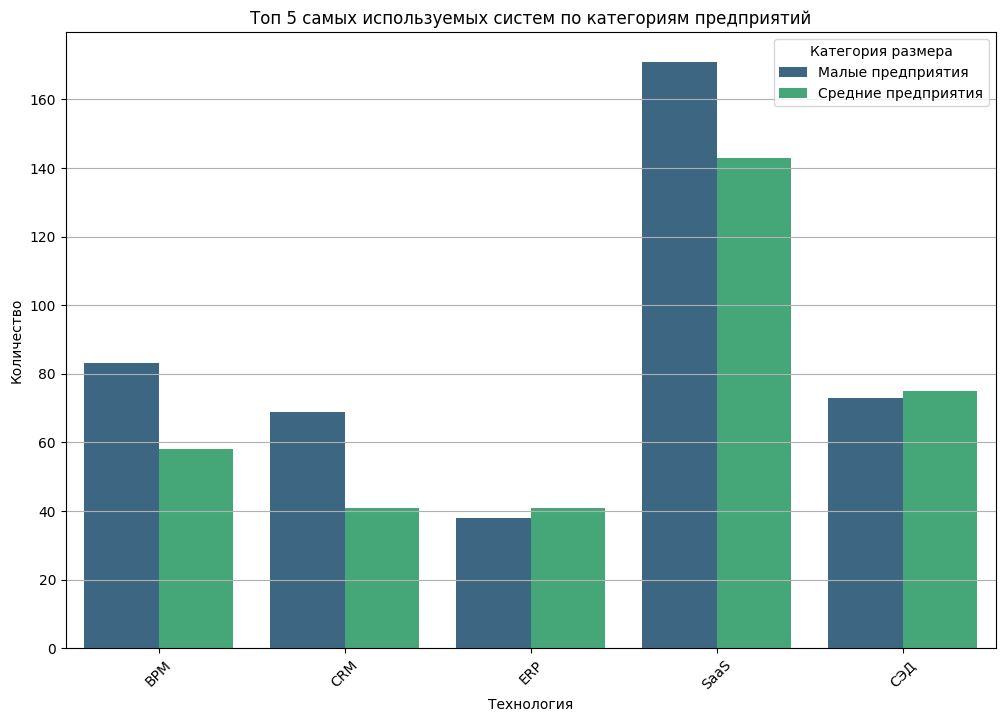

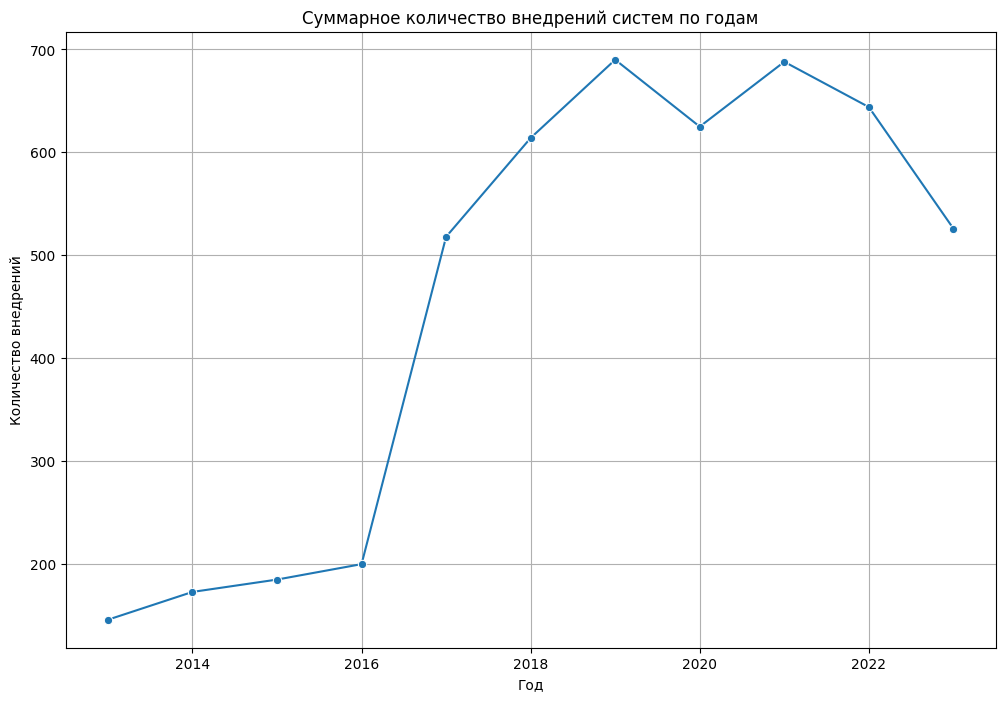

C:\Users\Home\AppData\Local\Temp\ipykernel_19112\696894470.py:47: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=industry_technology_counts.head(10), x='ind', y='total_counts', palette='viridis')


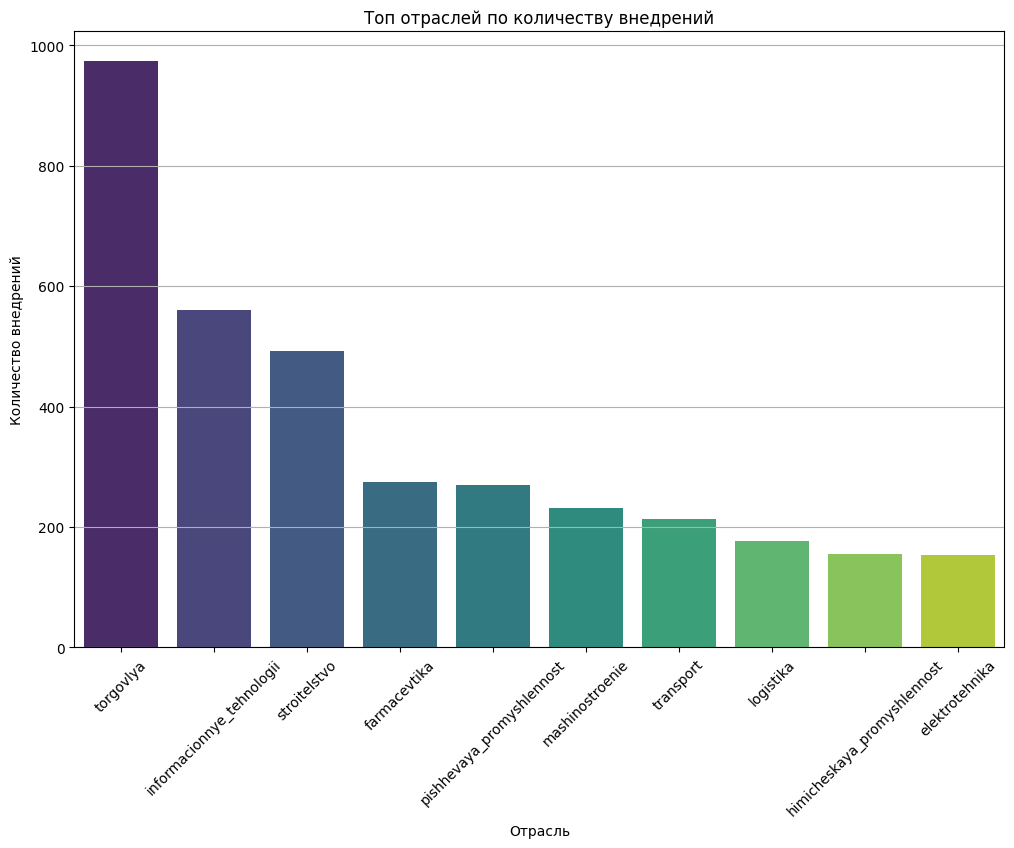

C:\Users\Home\AppData\Local\Temp\ipykernel_19112\696894470.py:65: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  top_5_technologies_by_industry = top_3_industry_technology_counts.groupby('ind').apply(lambda x: x.nlargest(5, 'counts')).reset_index(drop=True)


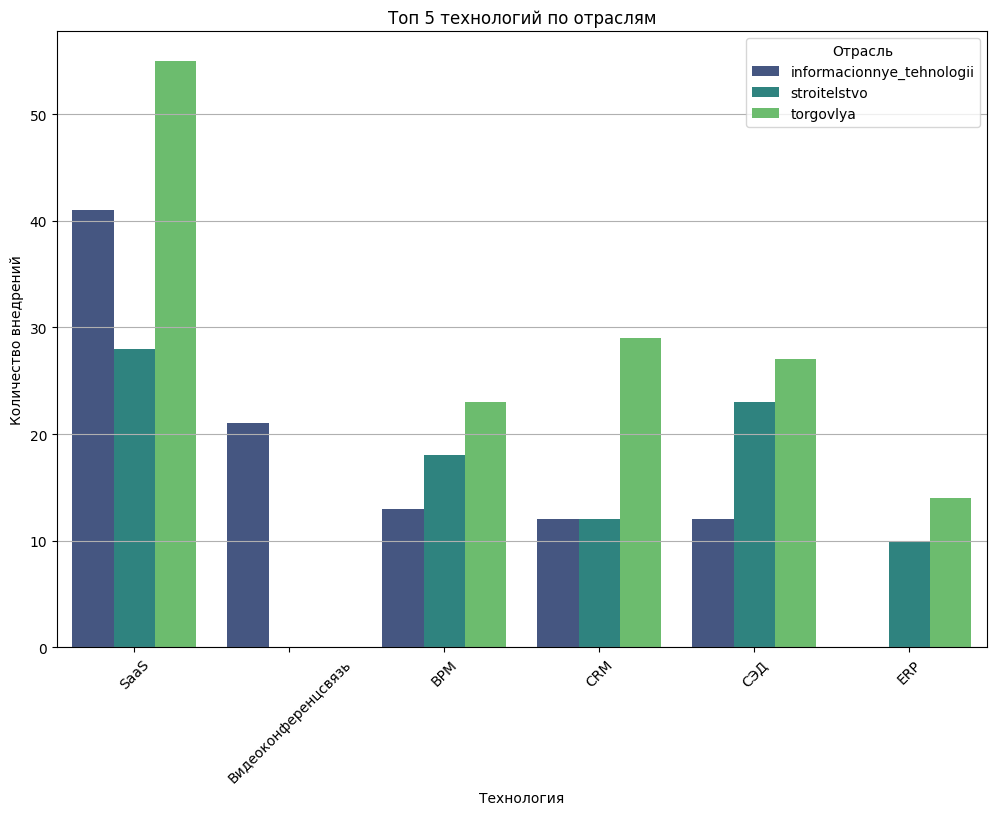

In [33]:
# Ensure the column names are correct
if 'firts_number_okved' in df_msp.columns and 'Технология' in df_msp.columns:
    # Convert 'firts_number_okved' to string if it's not already
    df_msp['firts_number_okved'] = df_msp['firts_number_okved'].astype(str)
    
    # Split the 'Технология' column by commas and explode the dataframe
    df_exploded = df_msp.assign(Технология=df_msp['Технология'].str.split(',')).explode('Технология')
    
    # Группировка по Технология и size_cat и суммирование
    technology_counts = df_exploded.groupby(['Технология', 'size_cat']).size().reset_index(name='counts')
    
    # Получение топ 5 самых используемых систем
    top_5_technologies = technology_counts.groupby('Технология')['counts'].sum().nlargest(5).index
    top_5_technology_counts = technology_counts[technology_counts['Технология'].isin(top_5_technologies)]
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_5_technology_counts, x='Технология', y='counts', hue='size_cat', palette='viridis')
    plt.title('Топ 5 самых используемых систем по категориям предприятий')
    plt.xlabel('Технология')
    plt.ylabel('Количество')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(title='Категория размера')
    plt.show()
    
    # Группировка по годам и суммирование количества внедрений
    yearly_technology_counts = df_exploded.groupby('year').size().reset_index(name='counts')
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.lineplot(data=yearly_technology_counts, x='year', y='counts', marker='o')
    plt.title('Суммарное количество внедрений систем по годам')
    plt.xlabel('Год')
    plt.ylabel('Количество внедрений')
    plt.grid(True)
    plt.show()
    
    # Группировка по отрасли (ind) и суммирование количества внедрений для каждой компании
    industry_technology_counts = df_exploded.groupby(['Компания', 'ind']).size().reset_index(name='counts')
    
    # Суммирование количества внедрений по отраслям
    industry_technology_counts = industry_technology_counts.groupby('ind')['counts'].sum().reset_index(name='total_counts').sort_values(by='total_counts', ascending=False)
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=industry_technology_counts.head(10), x='ind', y='total_counts', palette='viridis')
    plt.title('Топ отраслей по количеству внедрений')
    plt.xlabel('Отрасль')
    plt.ylabel('Количество внедрений')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.show()
    
    # Группировка по отраслям и технологиям, суммирование количества внедрений
    industry_technology_counts = df_exploded.groupby(['ind', 'Технология']).size().reset_index(name='counts')
    
    # Получение топ 3 отраслей
    top_3_industries = industry_technology_counts.groupby('ind')['counts'].sum().nlargest(3).index
    
    # Фильтрация данных для топ 3 отраслей
    top_3_industry_technology_counts = industry_technology_counts[industry_technology_counts['ind'].isin(top_3_industries)]
    
    # Получение топ 5 технологий для каждой отрасли
    top_5_technologies_by_industry = top_3_industry_technology_counts.groupby('ind').apply(lambda x: x.nlargest(5, 'counts')).reset_index(drop=True)
    
    # Построение графика
    plt.figure(figsize=(12, 8))
    sns.barplot(data=top_5_technologies_by_industry, x='Технология', y='counts', hue='ind', palette='viridis')
    plt.title('Топ 5 технологий по отраслям')
    plt.xlabel('Технология')
    plt.ylabel('Количество внедрений')
    plt.xticks(rotation=45)
    plt.grid(axis='y')
    plt.legend(title='Отрасль')
    plt.show()
else:
    print("One or both columns 'firts_number_okved' and 'Технология' do not exist in the DataFrame.")


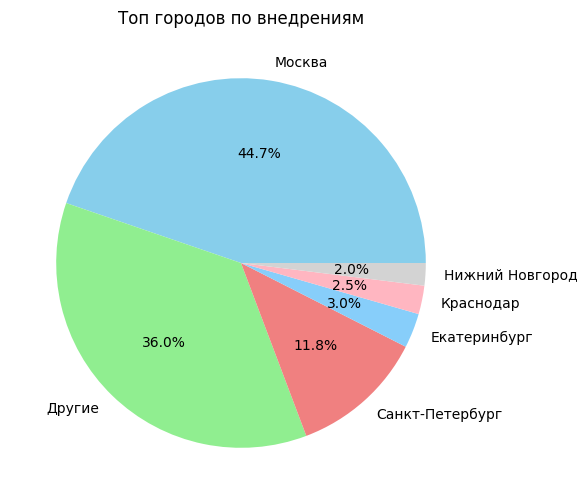

In [34]:
# Подсчет общего количества каждого города
city_counts = mean_financials_df['Город'].value_counts()

# Выбор топ 5 городов
top_5_cities = city_counts.head(5)

# Создание новой категории "Другие" для всех остальных городов
mean_financials_df['Город'] = mean_financials_df['Город'].apply(lambda x: x if x in top_5_cities.index else 'Другие')

# Подсчет количества компаний в каждом городе, включая категорию "Другие"
city_counts = mean_financials_df['Город'].value_counts()

# Построение круговой диаграммы
plt.figure(figsize=(10, 6))
city_counts.plot(kind='pie', autopct='%1.1f%%', colors=['skyblue', 'lightgreen', 'lightcoral', 'lightskyblue', 'lightpink', 'lightgray'])
plt.title('Топ городов по внедрениям')
plt.ylabel('')  # Убираем метку оси y
plt.show()

In [35]:
# Сохранение обновленного датасета
df_msp.to_csv("cleaned_dataset.csv", index=False)